In [1]:
import torch
from PIL import Image
from diffusers import AutoencoderKL, UNet2DModel, DDIMPipeline, DDIMScheduler, DDPMPipeline, DDPMScheduler, DistillationPipeline
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import math
import requests
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
    ToPILImage
)
from torch.utils.data import Dataset
from accelerate import Accelerator
import utils
from tqdm import tqdm
import torch.nn.functional as F


c:\Users\Ben\Anaconda3\envs\diffusers\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
torch.manual_seed(0)

In [3]:
training_config = utils.DiffusionTrainingArgs()

In [4]:
# Load an image of my dog for this example

image_url = "https://i.imgur.com/IJcs4Aa.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)

In [5]:
# Define the transforms to apply to the image for training
augmentations = utils.get_train_transforms(training_config)

In [9]:
class SingleImageDataset(Dataset):
    def __init__(self, image, batch_size):
        self.image = image
        self.batch_size = batch_size

    def __len__(self):
        return self.batch_size

    def __getitem__(self, idx):
        return self.image


In [10]:
train_image = augmentations(image.convert("RGB"))
train_dataset = SingleImageDataset(train_image, training_config.batch_size)

In [11]:
teacher = UNet2DModel.from_pretrained("bglick13/minnie-diffusion")
distiller = DistillationPipeline()

Downloading: 100%|██████████| 455M/455M [00:17<00:00, 25.7MB/s] 
Downloading: 100%|██████████| 665/665 [00:00<00:00, 332kB/s]


In [12]:
N = 1000
generator = torch.manual_seed(0)


In [13]:
teacher = UNet2DModel.from_pretrained("bglick13/minnie-diffusion")
N = 1000
distilled_images = []
for distill_step in range(2):
    print(f"Distill step {distill_step} from {N} -> {N // 2}")
    teacher, distilled_ema, distill_accelrator = distiller(teacher, N, train_dataset, epochs=300, batch_size=training_config.batch_size)
    N = N // 2
    new_scheduler = DDPMScheduler(num_train_timesteps=N, beta_schedule="squaredcos_cap_v2")
    pipeline = DDPMPipeline(
        unet=distill_accelrator.unwrap_model(distilled_ema.averaged_model if training_config.use_ema else teacher),
        scheduler=new_scheduler,
    )

    # run pipeline in inference (sample random noise and denoise)
    images = pipeline(generator=generator, batch_size=training_config.batch_size, output_type="numpy").images

    # denormalize the images and save to tensorboard
    images_processed = (images * 255).round().astype("uint8")
    distilled_images.append(images_processed[0])


Distill step 0 from 1000 -> 500


NameError: name 'DDPMScheduler' is not defined

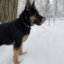

Distilled image 0


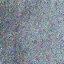

Distilled image 1


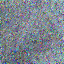

In [13]:
# Display train image for reference
train_image_display = train_image * 0.5 + 0.5
train_image_display = ToPILImage()(train_image_display)
display(train_image_display)

for i, image in enumerate(distilled_images):
    print(f"Distilled image {i}")
    display(Image.fromarray(image))
    Image.fromarray(image).save(f"distilled_{i}.png")

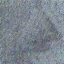

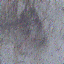

In [11]:
display(Image.fromarray(images_processed[0]))
display(Image.fromarray(images_processed[1]))